In [1]:
!pip install xgboost

In [12]:
# Imports

import pandas as pd
import json
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from matplotlib_venn import venn2
from sklearn.metrics import classification_report

# Processing

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

json_path = "/content/arxiv_data.json"
with open(json_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
print("Data Loaded:")
print(df.head())
print(df.columns)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data Loaded:
                                              titles  \
0  Survey on Semantic Stereo Matching / Semantic ...   
1  FUTURE-AI: Guiding Principles and Consensus Re...   
2  Enforcing Mutual Consistency of Hard Regions f...   
3  Parameter Decoupling Strategy for Semi-supervi...   
4  Background-Foreground Segmentation for Interio...   

                                           summaries                  terms  
0  Stereo matching is one of the widely used tech...         [cs.CV, cs.LG]  
1  The recent advancements in artificial intellig...  [cs.CV, cs.AI, cs.LG]  
2  In this paper, we proposed a novel mutual cons...         [cs.CV, cs.AI]  
3  Consistency training has proven to be an advan...                [cs.CV]  
4  To ensure safety in automated driving, the cor...         [cs.CV, cs.LG]  
Index(['titles', 'summaries', 'terms'], dtype='object')


<ipython-input-3-f1ad2d4e7b2f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(original_label_counts.keys()), y=list(original_label_counts.values()), palette='pastel')


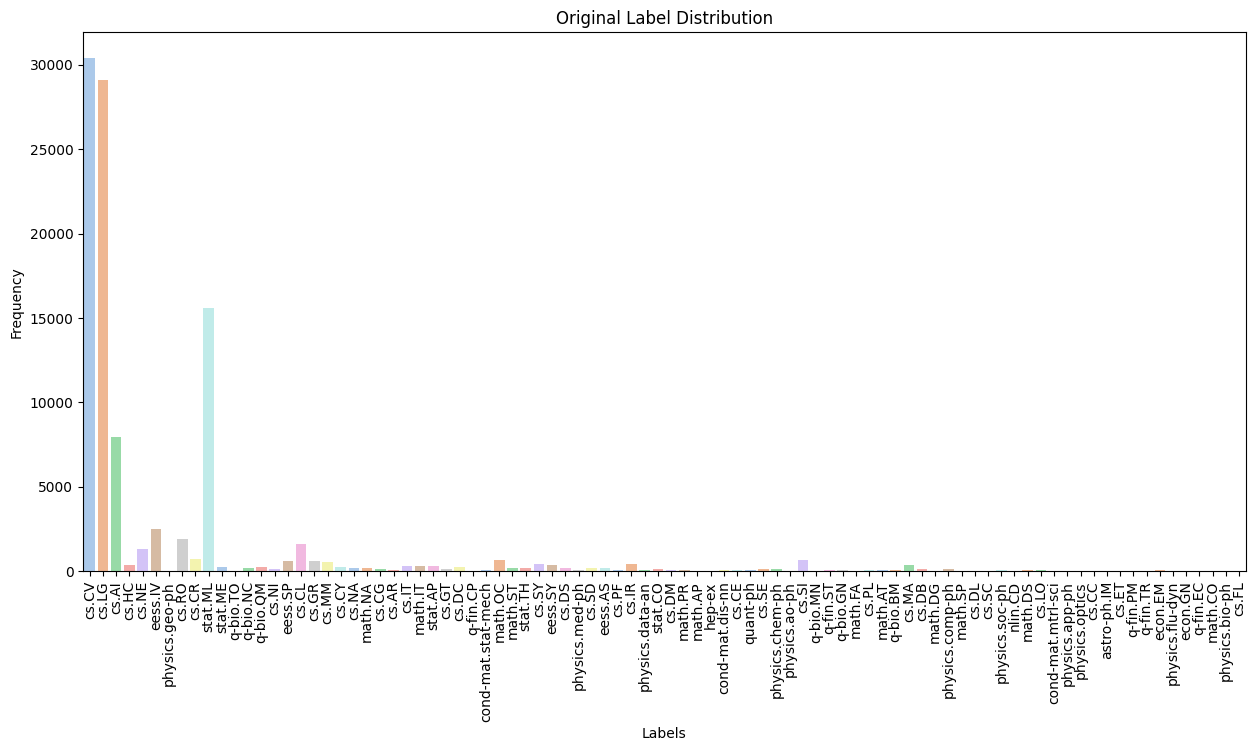

In [3]:
original_label_counts = Counter([label for sublist in df['terms'] for label in sublist])
plt.figure(figsize=(15, 7))
sns.barplot(x=list(original_label_counts.keys()), y=list(original_label_counts.values()), palette='pastel')
plt.title("Original Label Distribution")
plt.xticks(rotation=90)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()

In [4]:
total_samples = len(df)
min_percentage = 0.01
rare_threshold = total_samples * min_percentage

label_counts = Counter([label for sublist in df['terms'] for label in sublist])
rare_labels = {label for label, count in label_counts.items() if count < rare_threshold}

print(f"Rare Label Threshold: {rare_threshold}")
print(f"Number of Rare Labels: {len(rare_labels)}")

Rare Label Threshold: 517.74
Number of Rare Labels: 74


In [5]:
def replace_rare_labels(terms, rare_labels):
    return [label if label not in rare_labels else "other" for label in terms]

df['terms'] = df['terms'].apply(lambda x: replace_rare_labels(x, rare_labels))
df['terms'] = df['terms'].apply(lambda x: list(set(x)))

new_label_counts = Counter([label for sublist in df['terms'] for label in sublist])
all_labels = [label for sublist in df['terms'] for label in sublist]
label_counts = Counter(all_labels)

print(f"Total Labels (including 'other'): {len(label_counts)}")
print(f"Label Distribution After Classification:")
print(label_counts)

original_labels = set(original_label_counts.keys())
new_labels = set(new_label_counts.keys())

Total Labels (including 'other'): 15
Label Distribution After Classification:
Counter({'cs.CV': 30413, 'cs.LG': 29067, 'stat.ML': 15578, 'cs.AI': 7944, 'other': 5695, 'eess.IV': 2484, 'cs.RO': 1896, 'cs.CL': 1620, 'cs.NE': 1296, 'cs.CR': 717, 'cs.SI': 678, 'math.OC': 666, 'eess.SP': 621, 'cs.GR': 583, 'cs.MM': 523})


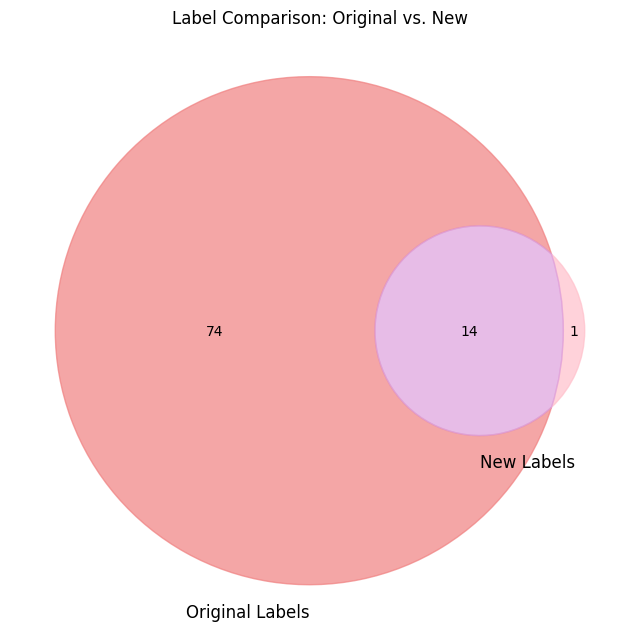

<ipython-input-6-d2993e2eb1af>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='pastel')


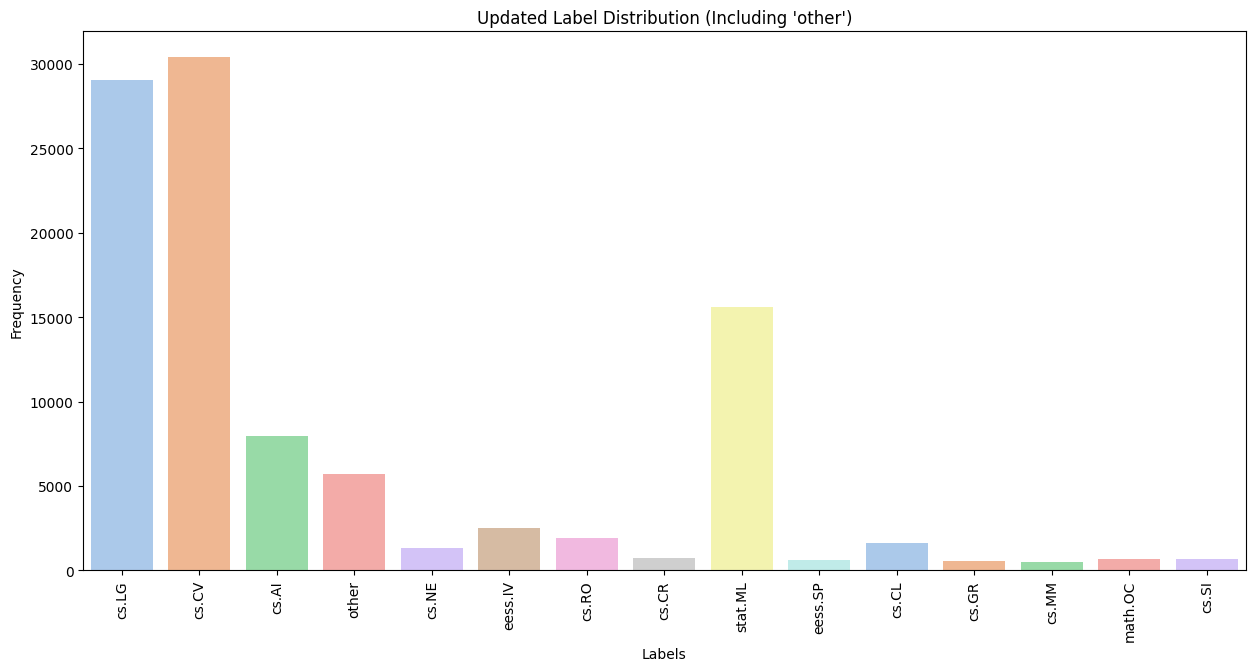

In [6]:
circle_colors = ['lightcoral', 'pink']
overlap_color = 'plum'

plt.figure(figsize=(8, 8))
venn = venn2([original_labels, new_labels], ("Original Labels", "New Labels"))

venn.get_patch_by_id('10').set_color(circle_colors[0])
venn.get_patch_by_id('01').set_color(circle_colors[1])
venn.get_patch_by_id('11').set_color(overlap_color)

for patch in ['10', '01', '11']:
    venn.get_patch_by_id(patch).set_alpha(0.7)

plt.title("Label Comparison: Original vs. New")
plt.show()

plt.figure(figsize=(15, 7))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='pastel')
plt.title("Updated Label Distribution (Including 'other')")
plt.xticks(rotation=90)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()

In [7]:
train, valtest = train_test_split(df, test_size=0.30, random_state=1234)
val, test = train_test_split(valtest, test_size=0.50, random_state=1234)
print(f"Split Sizes -> Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

val['terms'] = val['terms'].apply(lambda x: replace_rare_labels(x, rare_labels))
test['terms'] = test['terms'].apply(lambda x: replace_rare_labels(x, rare_labels))

Split Sizes -> Train: 36241, Validation: 7766, Test: 7767


In [8]:
print("Starting TF-IDF Vectorization...")
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 3), stop_words='english', max_df=0.85)
X_train_tfidf = tfidf.fit_transform(train['summaries'])
X_val_tfidf = tfidf.transform(val['summaries'])
X_test_tfidf = tfidf.transform(test['summaries'])
print("TF-IDF Vectorization Complete!")

mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(train['terms'])
y_val_bin = mlb.transform(val['terms'])
y_test_bin = mlb.transform(test['terms'])

Starting TF-IDF Vectorization...
TF-IDF Vectorization Complete!


In [9]:
# Models and Hyperparameters
models = {
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(class_weight='balanced')),
    "k-NN": OneVsRestClassifier(KNeighborsClassifier()),
    "Multinomial Naive Bayes": OneVsRestClassifier(MultinomialNB()),
    "XGBoost": OneVsRestClassifier(XGBClassifier(eval_metric='logloss')),
    "MLP": OneVsRestClassifier(MLPClassifier(max_iter=1000))
}

In [10]:
best_params = {
    "Random Forest": {
        'estimator__n_estimators': 300,
        'estimator__max_depth': 15
    },
    "k-NN": {
        'estimator__n_neighbors': 5
    },
    "Multinomial Naive Bayes": {
        'estimator__alpha': 0.1
    },
    "XGBoost": {
        'estimator__learning_rate': 0.1,
        'estimator__max_depth': 5,
        'estimator__n_estimators': 100
    },
    "MLP": {
        'estimator__hidden_layer_sizes': (100,),
        'estimator__alpha': 0.0001
    }
}

In [13]:
# Evaluate all models

results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} with predefined best parameters...")
    model.set_params(**best_params[model_name])

    # Training time
    start_time = time()
    model.fit(X_train_tfidf, y_train_bin)
    train_time = time() - start_time

    y_val_pred_bin = model.predict(X_val_tfidf)
    val_accuracy = accuracy_score(y_val_bin, y_val_pred_bin)
    val_f1_micro = f1_score(y_val_bin, y_val_pred_bin, average='micro', zero_division=0)
    val_f1_macro = f1_score(y_val_bin, y_val_pred_bin, average='macro', zero_division=0)

    print(f"\nModel: {model_name}")
    print(f"Training Time: {train_time:.2f}s")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Micro F1: {val_f1_micro:.4f}")
    print(f"Validation Macro F1: {val_f1_macro:.4f}")

    val_classification_report = classification_report(y_val_bin, y_val_pred_bin, target_names=mlb.classes_)
    with open(f"{model_name}_validation_report.txt", "w") as f:
        f.write(f"Classification Report for {model_name} (Validation Data)\n")
        f.write(val_classification_report)

    results[model_name] = {
        "Training Time": train_time,
        "Validation Accuracy": val_accuracy,
        "Validation Micro F1": val_f1_micro,
        "Validation Macro F1": val_f1_macro
    }

best_model_name = max(results, key=lambda x: results[x]["Validation Micro F1"])
best_model = models[best_model_name]
best_model.fit(X_train_tfidf, y_train_bin)
y_test_pred_bin = best_model.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test_bin, y_test_pred_bin)
test_f1_micro = f1_score(y_test_bin, y_test_pred_bin, average='micro', zero_division=0)
test_f1_macro = f1_score(y_test_bin, y_test_pred_bin, average='macro', zero_division=0)

print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Micro F1: {test_f1_micro:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")

test_classification_report = classification_report(y_test_bin, y_test_pred_bin, target_names=mlb.classes_)
with open(f"best_model_{best_model_name}_test_report.txt", "w") as f:
    f.write(f"Classification Report for Best Model ({best_model_name}) (Test Data)\n")
    f.write(test_classification_report)



Evaluating Random Forest with predefined best parameters...

Model: Random Forest
Training Time: 767.82s
Validation Accuracy: 0.3496
Validation Micro F1: 0.7222
Validation Macro F1: 0.5086

Evaluating k-NN with predefined best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: k-NN
Training Time: 0.51s
Validation Accuracy: 0.4187
Validation Micro F1: 0.7169
Validation Macro F1: 0.3480

Evaluating Multinomial Naive Bayes with predefined best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: Multinomial Naive Bayes
Training Time: 0.96s
Validation Accuracy: 0.4195
Validation Micro F1: 0.7470
Validation Macro F1: 0.3902

Evaluating XGBoost with predefined best parameters...

Model: XGBoost
Training Time: 1636.89s
Validation Accuracy: 0.4435
Validation Micro F1: 0.7453
Validation Macro F1: 0.3840

Evaluating MLP with predefined best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: MLP
Training Time: 7603.65s
Validation Accuracy: 0.5640
Validation Micro F1: 0.8049
Validation Macro F1: 0.6147


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model: MLP
Test Accuracy: 0.5664
Test Micro F1: 0.8027
Test Macro F1: 0.6098


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
